In [1]:
import numpy as np
import nysg_tools as ny 
import pandas as pd
from math import log10
import pyvisa as pyvisa
import matplotlib.pyplot as plt


In [85]:
start = 600
end = 130000
samples_per_decade = 10

ndecades = log10(end) - log10(start)
npoints = int(ndecades) * samples_per_decade
#a = np.linspace(log10(start), log10(end), num = npoints)
#points = np.power(10, a)
points = np.logspace(log10(start), log10(end), num=npoints, endpoint=True, base=10)
print(points)

[   600.            796.32009792   1056.87616391   1402.68621721
   1861.64537639   2470.77604735   3279.21437325   4352.17385132
   5776.20584572   7666.18134106  10174.55712692  13503.67387926
  17922.07817624  23786.18508025  31569.02872023  41898.4200693
  55607.58995346  73802.40246096  97950.56059015 130000.        ]


In [2]:
rm = pyvisa.ResourceManager()
rm.list_resources()

('USB0::0x0699::0x0353::1603553::INSTR',
 'USB0::0x0699::0x03C4::C010501::INSTR',
 'ASRL1::INSTR',
 'ASRL10::INSTR')

In [3]:
osci_name = "USB0::0x0699::0x03C4::C010501::INSTR"
fungen_name = "USB0::0x0699::0x0353::1603553::INSTR"

osci = rm.open_resource(osci_name)
fungen = rm.open_resource(fungen_name)

In [4]:
def get_osci(additional_info = False, plot=False):
    osci.write("DAT:SOU CH1")
    xze, xin = osci.query_ascii_values('WFMPRE:XZE?;XIN?', separator=';')
    yze1, ymu1, yoff1 = osci.query_ascii_values('WFMPRE:YZE?;YMU?;YOFF?;', separator=';')
    osci.write("DAT:SOU CH2")

    yze2, ymu2, yoff2 = osci.query_ascii_values('WFMPRE:YZE?;YMU?;YOFF?;', separator=';')

    osci.write('DAT:ENC RPB')
    osci.write('DAT:WID 1')

    osci.write("DAT:SOU CH1")
    data1 = osci.query_binary_values('CURV?', datatype='B', container=np.array)

    osci.write("DAT:SOU CH2")
    data2 = osci.query_binary_values('CURV?', datatype='B', container=np.array)

    tiempo = xze + np.arange(len(data1)) * xin

    data1v = (data1 - yoff1) * ymu1 + yze1
    data2v = (data2 - yoff2) * ymu2 + yze2
    
    if plot:
        plt.plot(tiempo,data1v)
        plt.plot(tiempo,data2v)

    if additional_info:
        extra = {"yze1":yze1,"ymu1":ymu1,"yoff1":yoff1,"yze2":yze2,"ymu2":ymu2,"yoff2":yoff2,"datach1raw":data1,"datach2raw":data2}
        return tiempo,data1v,data2v, extra

    return tiempo,data1v,data2v

def osci_autosave(filename,attrs,plot_saved=False):
    t,v1,v2 = get_osci()
    buffer =  pd.DataFrame({"time":t,"VCH1":v1,"VCH2":v2})

    buffer.attrs = attrs
    
    buffer.to_csv(f'{filename}{".csv"}')
    buffer.to_pickle(f'{filename}')

    if plot_saved:
        plt.plot(t,v1)
        plt.plot(t,v2)


def osci_autosave_simple(filename):
    t,v1,v2 = get_osci()
    buffer =  pd.DataFrame({"time":t,"VCH1":v1,"VCH2":v2})

    buffer.to_pickle(f'{filename}')

In [14]:
import time 

freq = points

overf = 1/np.array(freq)


# vals = pd.DataFrame({"time":t,"v1":v1,"v2":v2})
#1000, 5000, 10000, 15000, 30000,45000, 60000, 100000, 150000,200000, 500000

for (i,freq) in enumerate(freq):
    
    fungen.write(f'SOURCE1:FREQ {freq}')
    
    t, v1, v2 = get_osci()
    
    osci.write(f"HOR:MAI:SCALE {3/10 * 0.8 *overf[i]}")
    
    time.sleep(1)
    
    # data = pd.DataFrame({"time":t,"v1":v1,"v2":v2})
    
    # data.to_csv(f'data{i}')

In [19]:
#Primera medición

# for n,i in enumerate(points):#np.logspace(4,6,50):
#    fungen.write(f'SOURCE1:FREQ {i}')
#    osci.write(f"HOR:MAI:SCALE {3/10 * 0.8 *1/i}")
#    time.sleep(1)
# #    attrs = {"Freq":i, "Res":1000,"cap":0.001*10**(-6),"amplt":5,"inductancia":10*10**(-3),"onda":"senoidal"}
#    osci_autosave_simple(f"rcsweep/med{n}-{i}Hz")
   

In [20]:
#Segunda medición

# for n,i in enumerate(points):#np.logspace(4,6,50):
#    fungen.write(f'SOURCE1:FREQ {i}')
#    osci.write(f"HOR:MAI:SCALE {3/10 * 0.8 *1/i}")
#    time.sleep(1)
# #    attrs = {"Freq":i, "Res":1000,"cap":0.001*10**(-6),"amplt":5,"inductancia":10*10**(-3),"onda":"senoidal"}
#    osci_autosave_simple(f"rcsweep/med{n}Hz")

In [79]:
f = np.array([])
vin = np.array([])
vout = np.array([])
for n,i in enumerate(points):
    buffer = pd.read_pickle(f'rcsweep/med{n}Hz')
    f = np.append(f, i)    
    vout = np.append(vout,np.max(buffer['VCH2'])- np.min(buffer['VCH2']))
    vin = np.append(vin,np.max(buffer['VCH1'])- np.min(buffer['VCH1']))


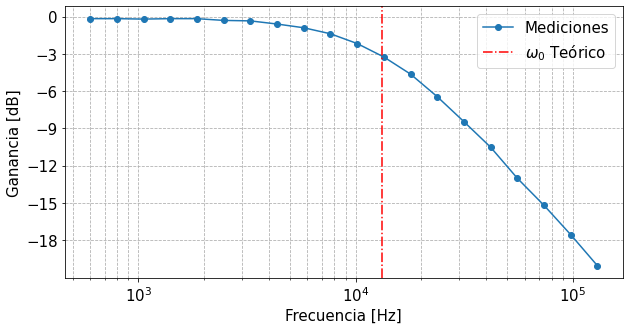

In [80]:
plt.rcParams['font.size'] = 15

plt.figure(figsize=(10,5))

# plt.plot(f,20*np.log10(vout/vin))
plt.plot(f,20*np.log10(vout/vin),marker='o',label='Mediciones')
plt.yticks([0,-3,-6,-9,-12,-15,-18])
plt.axvline(13262,linestyle='-.',c='r',label='$\omega_0$ Teórico')
plt.xscale("log")
plt.grid(linestyle='--',which='both')
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Ganancia [dB]")
plt.legend()
plt.savefig("Pasabajos.pdf")

In [76]:
#Tercera medición

# for n,i in enumerate(points):#np.logspace(4,6,50):
#    fungen.write(f'SOURCE1:FREQ {i}')
#    osci.write(f"HOR:MAI:SCALE {3/10 * 0.8 *1/i}")
#    time.sleep(1)
# #    attrs = {"Freq":i, "Res":1000,"cap":0.001*10**(-6),"amplt":5,"inductancia":10*10**(-3),"onda":"senoidal"}
#    osci_autosave_simple(f"rcsweep_highpass/med{n}Hz")

In [81]:
f = np.array([])
vin = np.array([])
vout = np.array([])
for n,i in enumerate(points):
    buffer = pd.read_pickle(f'rcsweep_highpass/med{n}Hz')
    f = np.append(f, i)    
    vout = np.append(vout,np.max(buffer['VCH2'])- np.min(buffer['VCH2']))
    vin = np.append(vin,np.max(buffer['VCH1'])- np.min(buffer['VCH1']))

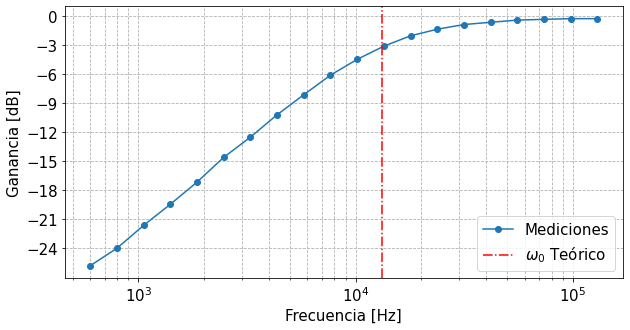

In [82]:
plt.rcParams['font.size'] = 15

plt.figure(figsize=(10,5))

# plt.plot(f,20*np.log10(vout/vin))
plt.plot(f,20*np.log10(vout/vin),marker='o',label='Mediciones')
plt.yticks([0,-3,-6,-9,-12,-15,-18,-21,-24])
plt.axvline(13262,linestyle='-.',c='r',label='$\omega_0$ Teórico')
plt.xscale("log")
plt.grid(linestyle='--',which='both')
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Ganancia [dB]")
plt.legend(loc=4)
plt.savefig("Pasaaltos.pdf")

# Integrador: 

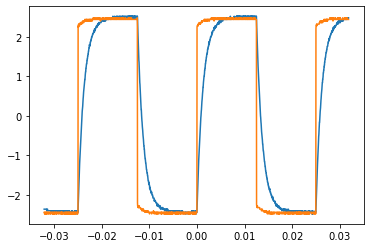

In [5]:
#####INTEGRADOR:
#med0 

# attrs = {"Freq":40, "Res":1200,"cap":1*10**(-6),"amplt":5,"onda_entrada":"cuadrada","Tipo_de_circuito":"Integrador"}

# osci_autosave("integrador/med0",attrs=attrs,plot_saved=True)

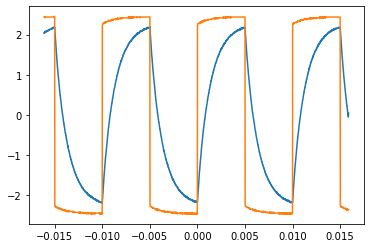

In [7]:
#####INTEGRADOR:
#med1

# attrs = {"Freq":100, "Res":1200,"cap":1*10**(-6),"amplt":5,"onda_entrada":"cuadrada","Tipo_de_circuito":"Integrador"}

# osci_autosave("integrador/med1",attrs=attrs,plot_saved=True)

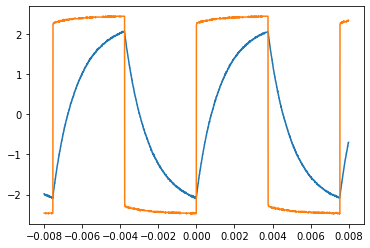

In [8]:
#med3

n=3
freq = 132.629 

# attrs = {"Freq":freq, "Res":1200,"cap":1*10**(-6),"amplt":5,"onda_entrada":"cuadrada","Tipo_de_circuito":"Integrador"}

# osci_autosave(f"integrador/med{n}",attrs=attrs,plot_saved=True)

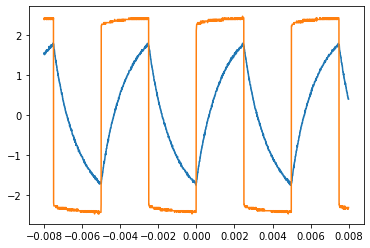

In [9]:
#med4

# n=4
# freq =200

# attrs = {"Freq":freq, "Res":1200,"cap":1*10**(-6),"amplt":5,"onda_entrada":"cuadrada","Tipo_de_circuito":"Integrador"}

# osci_autosave(f"integrador/med{n}",attrs=attrs,plot_saved=True)

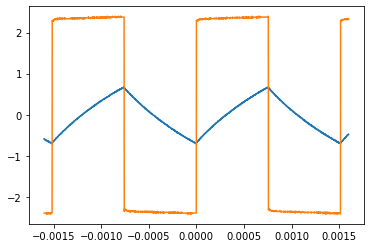

In [10]:
#med5

# n=5
# freq =660

# attrs = {"Freq":freq, "Res":1200,"cap":1*10**(-6),"amplt":5,"onda_entrada":"cuadrada","Tipo_de_circuito":"Integrador"}

# osci_autosave(f"integrador/med{n}",attrs=attrs,plot_saved=True)

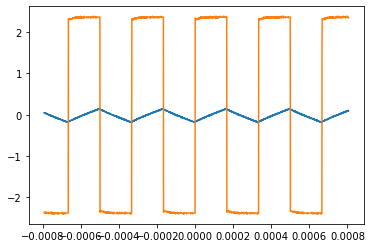

In [13]:
#med6

n=7
freq =300

attrs = {"Freq":freq, "Res":1200,"cap":1*10**(-6),"amplt":5,"onda_entrada":"cuadrada","Tipo_de_circuito":"Integrador"}

osci_autosave(f"integrador/med{n}",attrs=attrs,plot_saved=True)

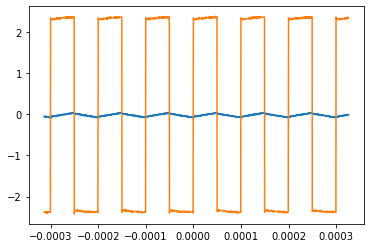

In [14]:
#med8

# n=8
# freq =10000

# attrs = {"Freq":freq, "Res":1200,"cap":1*10**(-6),"amplt":5,"onda_entrada":"cuadrada","Tipo_de_circuito":"Integrador"}

# osci_autosave(f"integrador/med{n}",attrs=attrs,plot_saved=True)

# RLC - Pasabanda

In [16]:
start = 1000
end = 100000
samples_per_decade = 50

ndecades = log10(end) - log10(start)
npoints = int(ndecades) * samples_per_decade
#a = np.linspace(log10(start), log10(end), num = npoints)
#points = np.power(10, a)
points = np.logspace(log10(start), log10(end), num=npoints, endpoint=True, base=10)
print(points)

[  1000.           1047.61575279   1097.49876549   1149.7569954
   1204.50354026   1261.85688307   1321.94114847   1384.88637139
   1450.8287785    1519.91108295   1592.28279334   1668.1005372
   1747.52840001   1830.7382803    1917.91026167   2009.23300257
   2104.90414451   2205.1307399    2310.12970008   2420.12826479
   2535.36449397   2656.08778295   2782.55940221   2915.05306283
   3053.85550883   3199.2671378    3351.60265094   3511.19173422
   3678.37977183   3853.52859371   4037.0172586    4229.24287439
   4430.62145758   4641.58883361   4862.60158007   5094.13801482
   5336.69923121   5590.81018251   5857.02081806   6135.90727341
   6428.07311728   6734.15065775   7054.80231072   7390.72203353
   7742.63682681   8111.3083079    8497.53435909   8902.15085445
   9326.03346883   9770.09957299  10235.31021899  10722.6722201
  11233.24032978  11768.11952435  12328.46739442  12915.49665015
  13530.4777458   14174.74162927  14849.68262254  15556.7614393
  16297.50834621  17073.52647

In [17]:
np.shape(points)

(100,)

In [19]:
# #RLC med0 
# import time 

# start = 1000
# end = 100000
# samples_per_decade = 50

# ndecades = log10(end) - log10(start)
# npoints = int(ndecades) * samples_per_decade
# #a = np.linspace(log10(start), log10(end), num = npoints)
# #points = np.power(10, a)
# points = np.logspace(log10(start), log10(end), num=npoints, endpoint=True, base=10)

# #USO ESTE ARRAY DE PUNTOS


# for n,i in enumerate(points):#np.logspace(4,6,50):
#    fungen.write(f'SOURCE1:FREQ {i}')
#    osci.write(f"HOR:MAI:SCALE {3/10 * 0.8 *1/i}")
#    time.sleep(1)
# #    attrs = {"Freq":i, "Res":1000,"cap":0.001*10**(-6),"amplt":5,"inductancia":10*10**(-3),"onda":"senoidal"}
#    osci_autosave_simple(f"RLC/med{n}")

In [22]:
f = np.array([])
vin = np.array([])
vout = np.array([])
for n,i in enumerate(points):
    buffer = pd.read_pickle(f'RLC/med{n}')
    f = np.append(f, i)    
    vout = np.append(vout,np.max(buffer['VCH2'])- np.min(buffer['VCH2']))
    vin = np.append(vin,np.max(buffer['VCH1'])- np.min(buffer['VCH1']))


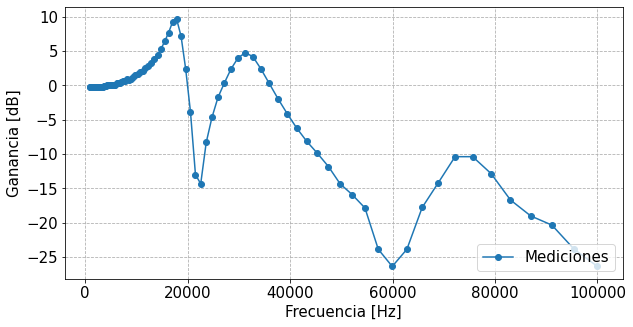

In [33]:
plt.rcParams['font.size'] = 15

plt.figure(figsize=(10,5))

# plt.plot(f,20*np.log10(vout/vin))
plt.plot(f,20*np.log10(vin/vout),marker='o',label='Mediciones')
# plt.yticks([0,-3,-6,-9,-12,-15,-18,-21,-24])
# plt.axvline(13262,linestyle='-.',c='r',label='$\omega_0$ Teórico')
# plt.xscale("log")
plt.grid(linestyle='--',which='both')
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Ganancia [dB]")
plt.legend(loc=4)
# plt.savefig("Pasaaltos.pdf")

In [36]:
buffer = pd.read_pickle(f'RLC/med{3}')
f = points[3]
# f = np.append(f, i)    
vin = np.append(vout,np.max(buffer['VCH2'])- np.min(buffer['VCH2']))
vout = np.append(vin,np.max(buffer['VCH1'])- np.min(buffer['VCH1']))

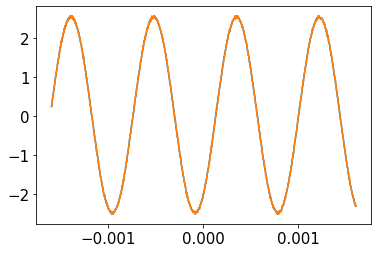

In [40]:
plt.plot(buffer['time'],buffer['VCH2'])
plt.plot(buffer['time'],buffer['VCH2'])

In [56]:
osci.query("MEASU:MEAS6:VAL?")

'5.1200\n'

In [118]:
#La medicióñ RLC 2 es el mismo circuito de antes, pero midiendo otros datos


# #RLC med0 
import time 

start = 10000
end = 100000
samples_per_decade = 50

ndecades = log10(end) - log10(start)
npoints = int(ndecades) * samples_per_decade
#a = np.linspace(log10(start), log10(end), num = npoints)
#points = np.power(10, a)
points = np.logspace(log10(start), log10(end), num=npoints, endpoint=True, base=10)

#USO ESTE ARRAY DE PUNTOS
v1 = np.array([])
phase = np.array([])
v2 = np.array([])

for n,i in enumerate(points):#np.logspace(4,6,50):
   fungen.write(f'SOURCE1:FREQ {i}')
   osci.write(f"HOR:MAI:SCALE {4/10 * 0.8 *1/i}")

   osci_autosave_simple(f"RLC_2/med{n}")
   time.sleep(1)
#    attrs = {"Freq":i, "Res":1000,"cap":0.001*10**(-6),"amplt":5,"inductancia":10*10**(-3),"onda":"senoidal"}

In [82]:
# #phase = array(['99.0000E+36\n', '-12.1154\n', '99.0000E+36\n', '-13.6268\n',
#        '-13.9227\n', '-16.3006\n', '-17.8905\n', '-20.1691\n',
#        '-22.4000\n', '-28.1119\n', '-34.3486\n', '-41.2284\n',
#        '-55.3041\n', '-82.0253\n', '-115.9322\n', '-140.1548\n',
#        '-152.1290\n', '99.0000E+36\n', '-73.8129\n', '-29.3878\n',
#        '-23.5547\n', '-29.5082\n', '-37.1613\n', '-44.8989\n',
#        '-61.9811\n', '-82.2222\n', '-104.9223\n', '-124.7283\n',
#        '-141.0256\n', '-149.4643\n', '-154.6875\n', '-158.2353\n',
#        '-161.4433\n', '99.0000E+36\n', '-162.2188\n', '-162.4252\n',
#        '6.3744\n', '20.6557\n', '-159.2185\n', '-60.0000\n', '103.1211\n',
#        '130.3185\n', '-48.2927\n', '-74.0930\n', '-115.9951\n',
#        '-133.5190\n', '22.1918\n', '40.9091\n', '9.1343\n', '47.4194\n'],
#       dtype='<U32')

array(['99.0000E+36\n', '-12.1154\n', '99.0000E+36\n', '-13.6268\n',
       '-13.9227\n', '-16.3006\n', '-17.8905\n', '-20.1691\n',
       '-22.4000\n', '-28.1119\n', '-34.3486\n', '-41.2284\n',
       '-55.3041\n', '-82.0253\n', '-115.9322\n', '-140.1548\n',
       '-152.1290\n', '99.0000E+36\n', '-73.8129\n', '-29.3878\n',
       '-23.5547\n', '-29.5082\n', '-37.1613\n', '-44.8989\n',
       '-61.9811\n', '-82.2222\n', '-104.9223\n', '-124.7283\n',
       '-141.0256\n', '-149.4643\n', '-154.6875\n', '-158.2353\n',
       '-161.4433\n', '99.0000E+36\n', '-162.2188\n', '-162.4252\n',
       '6.3744\n', '20.6557\n', '-159.2185\n', '-60.0000\n', '103.1211\n',
       '130.3185\n', '-48.2927\n', '-74.0930\n', '-115.9951\n',
       '-133.5190\n', '22.1918\n', '40.9091\n', '9.1343\n', '47.4194\n'],
      dtype='<U32')

In [83]:
# v1 =array(['99.0000E+36\n', '6.0800\n', '99.0000E+36\n', '6.4000\n',
#        '6.7200\n', '6.8800\n', '7.2000\n', '7.6800\n', '8.1600\n',
#        '8.9600\n', '9.9200\n', '11.2800\n', '13.1200\n', '14.1600\n',
#        '12.0800\n', '7.6800\n', '4.0000\n', '99.0000E+36\n',
#        '720.0000E-3\n', '1.6800\n', '2.7200\n', '3.7600\n', '4.8800\n',
#        '6.0800\n', '7.3600\n', '8.0000\n', '7.6800\n', '6.5600\n',
#        '5.2800\n', '4.1600\n', '3.2000\n', '2.5600\n', '2.0800\n',
#        '99.0000E+36\n', '1.2800\n', '960.0000E-3\n', '800.0000E-3\n',
#        '640.0000E-3\n', '400.0000E-3\n', '240.0000E-3\n', '320.0000E-3\n',
#        '640.0000E-3\n', '960.0000E-3\n', '1.4400\n', '1.4400\n',
#        '1.1200\n', '800.0000E-3\n', '640.0000E-3\n', '480.0000E-3\n',
#        '320.0000E-3\n'], dtype='<U32')

array(['99.0000E+36\n', '6.0800\n', '99.0000E+36\n', '6.4000\n',
       '6.7200\n', '6.8800\n', '7.2000\n', '7.6800\n', '8.1600\n',
       '8.9600\n', '9.9200\n', '11.2800\n', '13.1200\n', '14.1600\n',
       '12.0800\n', '7.6800\n', '4.0000\n', '99.0000E+36\n',
       '720.0000E-3\n', '1.6800\n', '2.7200\n', '3.7600\n', '4.8800\n',
       '6.0800\n', '7.3600\n', '8.0000\n', '7.6800\n', '6.5600\n',
       '5.2800\n', '4.1600\n', '3.2000\n', '2.5600\n', '2.0800\n',
       '99.0000E+36\n', '1.2800\n', '960.0000E-3\n', '800.0000E-3\n',
       '640.0000E-3\n', '400.0000E-3\n', '240.0000E-3\n', '320.0000E-3\n',
       '640.0000E-3\n', '960.0000E-3\n', '1.4400\n', '1.4400\n',
       '1.1200\n', '800.0000E-3\n', '640.0000E-3\n', '480.0000E-3\n',
       '320.0000E-3\n'], dtype='<U32')

In [84]:
# v2 = array(['99.0000E+36\n', '4.8800\n', '99.0000E+36\n', '4.8800\n',
#        '4.8800\n', '4.8800\n', '4.8800\n', '4.8800\n', '4.8000\n',
#        '4.7200\n', '4.7200\n', '4.7200\n', '4.5600\n', '4.4800\n',
#        '4.5600\n', '4.7200\n', '4.8000\n', '99.0000E+36\n', '4.8800\n',
#        '4.8800\n', '4.8800\n', '4.8000\n', '4.7200\n', '4.7200\n',
#        '4.5600\n', '4.5600\n', '4.5600\n', '4.5600\n', '4.6400\n',
#        '4.7200\n', '4.7200\n', '4.7200\n', '4.8800\n', '99.0000E+36\n',
#        '4.8800\n', '4.8800\n', '4.8800\n', '4.8800\n', '4.8800\n',
#        '4.8800\n', '4.8800\n', '4.8800\n', '4.8800\n', '4.7200\n',
#        '4.7200\n', '4.7200\n', '4.8800\n', '4.8800\n', '4.8800\n',
#        '4.8800\n'], dtype='<U32')

array(['99.0000E+36\n', '4.8800\n', '99.0000E+36\n', '4.8800\n',
       '4.8800\n', '4.8800\n', '4.8800\n', '4.8800\n', '4.8000\n',
       '4.7200\n', '4.7200\n', '4.7200\n', '4.5600\n', '4.4800\n',
       '4.5600\n', '4.7200\n', '4.8000\n', '99.0000E+36\n', '4.8800\n',
       '4.8800\n', '4.8800\n', '4.8000\n', '4.7200\n', '4.7200\n',
       '4.5600\n', '4.5600\n', '4.5600\n', '4.5600\n', '4.6400\n',
       '4.7200\n', '4.7200\n', '4.7200\n', '4.8800\n', '99.0000E+36\n',
       '4.8800\n', '4.8800\n', '4.8800\n', '4.8800\n', '4.8800\n',
       '4.8800\n', '4.8800\n', '4.8800\n', '4.8800\n', '4.7200\n',
       '4.7200\n', '4.7200\n', '4.8800\n', '4.8800\n', '4.8800\n',
       '4.8800\n'], dtype='<U32')

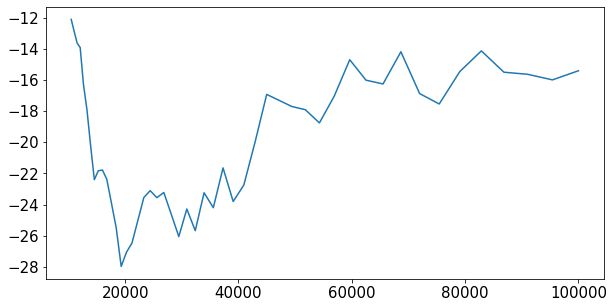

In [116]:
plt.figure(figsize=(10,5))
plt.plot(np.asarray(points[phase.astype(float)<10E10],dtype=float),np.unwrap(np.asarray(phase[phase.astype(float)<10E10],dtype=float)))

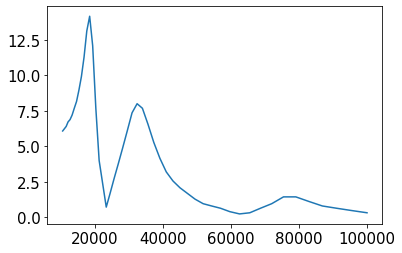

In [115]:
plt.plot(np.asarray(points[phase.astype(float)<10E10],dtype=float),np.asarray(v1[phase.astype(float)<10E10],dtype=float))